# Imports

In [1]:
import pandas as pd
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
#import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
#import xgboost as xgb
#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
import optuna as optuna
from optuna.samplers import TPESampler, NSGAIISampler, CmaEsSampler, GridSampler




### Import data

Train set

In [807]:
import os
import pandas as pd
from datetime import datetime

# Define the path to the CSV files
directory = r"C:\Users\maorb\CSVs\Metaculus_Csvs_train"
# Dictionary to hold individual DataFrames
df_dict = {}

# List to hold individual DataFrames for merging
df_list = []

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        
            # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
            
            # Extract date from filename
            # Adjust the slicing based on your filename pattern
            # Example: If filename is 'data_2023-07-something.csv', and date is at positions 4 to 12
            # Modify this according to your actual filename structure
        date_str = filename.split('.')[0][4:12]  # e.g., '2023-07'
        df_dict[date_str] = df  
        df_list.append(df)
           

# Example: Accessing individual DataFrames
# For example, to access July 2023 data:
# july_2023_df = df_dict.get("07_2023")

# Merge all DataFrames
if df_list:
    merged_df = pd.concat(df_list, ignore_index=True)
    
    # Define the path for the merged DataFrame
    merged_file_path = os.path.join(directory, "merged_df.csv")
    
    # Save the merged DataFrame to a CSV file
    merged_df.to_csv(merged_file_path, index=False)
    print(f"Merged DataFrame saved as {merged_file_path}")
else:
    print("No CSV files were processed.")

# Optional: Display the keys (dates) of the loaded DataFrames
print("Loaded DataFrames for the following dates:")
for key in df_dict.keys():
    print(key)


Merged DataFrame saved as C:\Users\maorb\CSVs\Metaculus_Csvs_train\merged_df.csv
Loaded DataFrames for the following dates:
01_01_20
01_01_21
01_01_22
01_01_23
01_01_24
05_020_2
05_20_20
05_20_22
05_20_23
05_20_24
09_20_20
09_20_21
09_20_22
09_20_23


Test set

In [864]:
import os
import pandas as pd
from datetime import datetime

# Define the path to the CSV files
directory = r"C:\Users\maorb\CSVs\Metaculus_Csvs_test"
# Dictionary to hold individual DataFrames
df_dict = {}

# List to hold individual DataFrames for merging
df_list = []

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        
            # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
            
            # Extract date from filename
            # Adjust the slicing based on your filename pattern
            # Example: If filename is 'data_2023-07-something.csv', and date is at positions 4 to 12
            # Modify this according to your actual filename structure
        date_str = filename.split('.')[0][4:12]  # e.g., '2023-07'
        df_dict[date_str] = df  
        df_list.append(df)
           

# Example: Accessing individual DataFrames
# For example, to access July 2023 data:
# july_2023_df = df_dict.get("07_2023")

# Merge all DataFrames
if df_list:
    merged_df_test = pd.concat(df_list, ignore_index=True)
    
    # Define the path for the merged DataFrame
    merged_file_path = os.path.join(directory, "merged_df.csv")
    
    # Save the merged DataFrame to a CSV file
    merged_df.to_csv(merged_file_path, index=False)
    print(f"Merged DataFrame saved as {merged_file_path}")
else:
    print("No CSV files were processed.")

# Optional: Display the keys (dates) of the loaded DataFrames
print("Loaded DataFrames for the following dates:")
for key in df_dict.keys():
    print(key)


Merged DataFrame saved as C:\Users\maorb\CSVs\Metaculus_Csvs_test\merged_df.csv
Loaded DataFrames for the following dates:
01_01_17
01_01_18
01_01_19
01_06_18
05_20_19
06_01_17
09_20_19


In [866]:
merge_test_dup_rows = merged_df_test[merged_df_test.duplicated()]
merged_test = merged_df_test.drop(merge_test_dup_rows.index)

In [836]:
#find duplicate rows

duplicate_rows = merged_df[merged_df.duplicated()]

In [868]:
merged_df1 = merged_df.copy() #df without title
merged_df1['Response_date'] = pd.to_datetime(merged_df1['Response_date'],errors = 'coerce')

merged_df1.drop(columns = ['title'],inplace = True)

In [914]:
merged_no_duplicates = merged_df1.drop(duplicate_rows.index)

In [811]:
#merged_df.to_csv(r"C:\Users\maorb\CSVs\Metaculus_Csvs_train\merged_df.csv")

### Remove columns and tidy

In [540]:
merged_df1 = merged_df.copy() #df without title
merged_df1['Response_date'] = pd.to_datetime(merged_df1['Response_date'],errors = 'coerce')

merged_df1.drop(columns = ['title'],inplace = True)

In [974]:
import pandas as pd
import numpy as np

def get_half_rows(group):
    """Get the first half of rows for each group."""
    return group.iloc[:len(group) // 2]

def extract_time_features(df1):
    """Extract basic time-based features from the Response_date column."""
    df1['year'] = df1['Response_date'].dt.year
    df1['month'] = df1['Response_date'].dt.month
    df1['day'] = df1['Response_date'].dt.day
    df1['weekday'] = df1['Response_date'].dt.weekday
    df1['hour'] = df1['Response_date'].dt.hour
    df1['minute'] = df1['Response_date'].dt.minute
    df1['quarter'] = df1['Response_date'].dt.quarter
    df1['weekofyear'] = df1['Response_date'].dt.isocalendar().week
    df1['dayofyear'] = df1['Response_date'].dt.dayofyear
    df1['is_weekend'] = df1['weekday'].isin([5, 6]).astype(int)
    df1['is_month_start'] = df1['Response_date'].dt.is_month_start.astype(int)
    df1['is_month_end'] = df1['Response_date'].dt.is_month_end.astype(int)
    return df1

def generate_cyclical_features(df1):
    """Generate cyclical features for time variables."""
    cyclical_cols = {
        'hour': 24, 'weekday': 7, 'month': 12, 'day': 31,
        'minute': 60, 'weekofyear': 53, 'dayofyear': 365
    }
    for col, max_val in cyclical_cols.items():
        df1[f'{col}_sin'] = np.sin(df1[col] * 2 * np.pi / max_val)
        df1[f'{col}_cos'] = np.cos(df1[col] * 2 * np.pi / max_val)
    return df1

def calculate_lag_features(df1, lag_intervals):
    """Calculate lag features using merge_asof with correct sorting order."""
    # Create a copy of the original DataFrame for merging
    original_df = df1[['id', 'Response_date', 'Unique_predictors']].copy()

    # Iterate over each lag interval and compute lag features using merge_asof
    for lag_name, lag_delta in lag_intervals.items():
        # Calculate the lagged time in the left DataFrame
        df1[f'{lag_name}_time'] = df1['Response_date'] - lag_delta

        # Prepare the right DataFrame from the original data
        right_df = original_df.copy()
        right_df.rename(columns={
            'Response_date': f'{lag_name}_response_date',
            'Unique_predictors': f'{lag_name}'
        }, inplace=True)

        # Sort both DataFrames by the datetime feature first, then 'id'
        df1 = df1.sort_values([f'{lag_name}_time', 'id'])
        right_df = right_df.sort_values([f'{lag_name}_response_date', 'id'])

        # Perform as-of merge within each 'id' group
        df1 = pd.merge_asof(
            df1,
            right_df,
            left_on=f'{lag_name}_time',
            right_on=f'{lag_name}_response_date',
            by='id',
            direction='backward'
        )

        # Drop unnecessary columns
        df1.drop(columns=[f'{lag_name}_time', f'{lag_name}_response_date'], inplace=True)

    return df1

def calculate_agg_features(df1, groupby_col='id'):
    """Calculate mean and median cyclical features."""
    agg_cols = ['hour', 'weekday', 'month', 'day', 'minute', 'weekofyear', 'dayofyear']
    mean_dict = {f'{col}_sin': 'mean' for col in agg_cols}
    mean_dict.update({f'{col}_cos': 'mean' for col in agg_cols})
    means = df1.groupby(groupby_col).agg(mean_dict).reset_index()
    
    median_dict = {f'{col}_sin': 'median' for col in agg_cols}
    median_dict.update({f'{col}_cos': 'median' for col in agg_cols})
    medians = df1.groupby(groupby_col).agg(median_dict).reset_index()
    
    return means, medians

def generate_bedtime_feature(df1, bedtime_hour=12, bedtime_minute=30):
    """Generate after_bedtime feature based on given bedtime hour and minute."""
    df1['after_bedtime'] = (
        (df1['hour'] < bedtime_hour) |
        ((df1['hour'] == bedtime_hour) & (df1['minute'] > bedtime_minute))
    ).astype(int)
    return df1

def combine_features(df1, means, medians, time_between_mean, unique_predictors, lag_features):
    """Combine all generated features into the final dataframe using both means and medians."""
    # Merge mean and median features on 'id'
    combined = means.merge(medians, on='id', suffixes=('_mean', '_median'))
    
    # Create a DataFrame from unique_predictors and lag_features
    other_features = pd.DataFrame({
        'id': unique_predictors.index,
        'unique_predictors': unique_predictors.values,
        'after_bedtime': df1.groupby('id')['after_bedtime'].first().values,
        'Time_between_response_mean': time_between_mean['Time_between_response_mean'].values
    })
    
    # Add lag features
    for lag_name, lag_series in lag_features.items():
        other_features[lag_name] = lag_series.values
    
    # Merge all features
    combined = combined.merge(other_features, on='id', how='left')
    
    return combined

def Feature_generation(df1):
    """Main function to generate all features."""
    df1 = df1.copy()
    
    df1['publish_time'] = pd.to_datetime(df1['publish_time'], errors='coerce')
    df1['Response_date'] = pd.to_datetime(df1['Response_date'], errors='coerce')
    
    # Step 1: Extract time features
    df1 = extract_time_features(df1)
    
    # Step 2: Generate cyclical features
    df1 = generate_cyclical_features(df1)
    
    # Step 3: Generate bedtime feature
    df1 = generate_bedtime_feature(df1)
    
    # Step 4: Calculate mean and median for full and half datasets
    full_means, full_medians = calculate_agg_features(df1)
    half_df = df1.groupby('id').apply(get_half_rows).reset_index(drop=True)
    half_means, half_medians = calculate_agg_features(half_df)
    
    # Step 5: Add lag features using the optimized method
    # Define lag intervals using pandas Timedelta objects
    lag_intervals = {
        'lag_2day': pd.Timedelta(days=2),
        'lag_1day': pd.Timedelta(days=1),
        'lag_5hours': pd.Timedelta(hours=5),
        'lag_1hour': pd.Timedelta(hours=1)
    }
    
    # Calculate lag features for the full dataset
    df1 = calculate_lag_features(df1, lag_intervals)
    
    # Calculate lag features for the half dataset
    half_df = calculate_lag_features(half_df, lag_intervals)
    
    # Step 6: Calculate Time_between_response_mean per 'id' for full_df1
    df1 = df1.sort_values(by=['id', 'Response_date'])
    df1['Time_between_response'] = df1.groupby('id')['Response_date'].diff().dt.total_seconds()
    time_between_mean_full = df1.groupby('id')['Time_between_response'].mean().reset_index(name='Time_between_response_mean')
    df1 = df1.merge(time_between_mean_full, on='id', how='left')
    
    # Step 6.1: Calculate Time_between_response_mean for half_df
    half_df = half_df.sort_values(by=['id', 'Response_date'])
    half_df['Time_between_response'] = half_df.groupby('id')['Response_date'].diff().dt.total_seconds()
    time_between_mean_half = half_df.groupby('id')['Time_between_response'].mean().reset_index(name='Time_between_response_mean')
    half_df = half_df.merge(time_between_mean_half, on='id', how='left')
    
    # Step 7: Get unique_predictors for full and half datasets
    unique_predictors_full = df1.groupby('id')['Unique_predictors'].max()
    unique_predictors_half = half_df.groupby('id')['Unique_predictors'].max()
    
    # Step 8: Combine lag features for full and half datasets
    lag_features_full = {
        lag_name: df1.groupby('id')[lag_name].last() for lag_name in lag_intervals.keys()
    }
    
    lag_features_half = {
        lag_name: half_df.groupby('id')[lag_name].last() for lag_name in lag_intervals.keys()
    }
    
    # Step 9: Combine both full and half data aggregation
    df1_n_full = combine_features(
        df1, 
        full_means, full_medians, 
        time_between_mean_full, 
        unique_predictors_full, 
        lag_features_full
    )
    
    df1_n_half = combine_features(
        half_df, 
        half_means, half_medians, 
        time_between_mean_half, 
        unique_predictors_half, 
        lag_features_half
    )
    
    # Step 10: Rename half features with '_half' suffix, excluding 'id'
    half_feature_cols = [col for col in df1_n_half.columns if col != 'id']
    df1_n_half = df1_n_half.rename(columns={col: f"{col}_half" for col in half_feature_cols})
    
    # Step 11: Merge full and half features on 'id'
    df1_n = df1_n_full.merge(df1_n_half, on='id', how='left')
    
    # Step 12: Return the final aggregated feature set
    return df1_n, df1


In [977]:
df1_n_dup,df1_no_dup = Feature_generation(merged_no_duplicates)

In [975]:
df1_n,df1_post = Feature_generation(merged_df1)

(0.0, 500000.0)

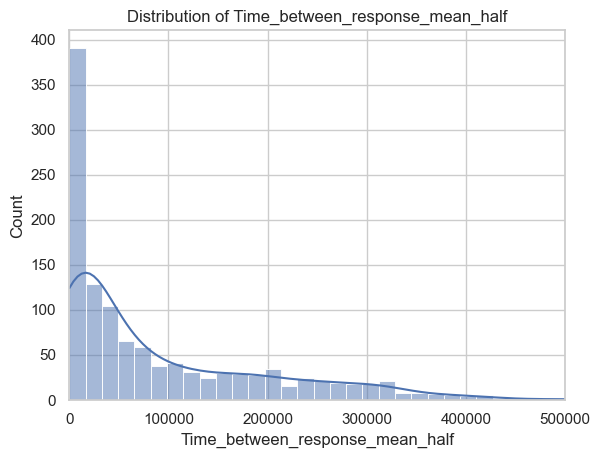

In [972]:
sns.histplot(df1_n_dup['Time_between_response_mean_half'], bins=50, kde=True)
plt.title('Distribution of Time_between_response_mean_half')
plt.xlabel('Time_between_response_mean_half')
plt.xlim(0, 500000)

(0.0, 500000.0)

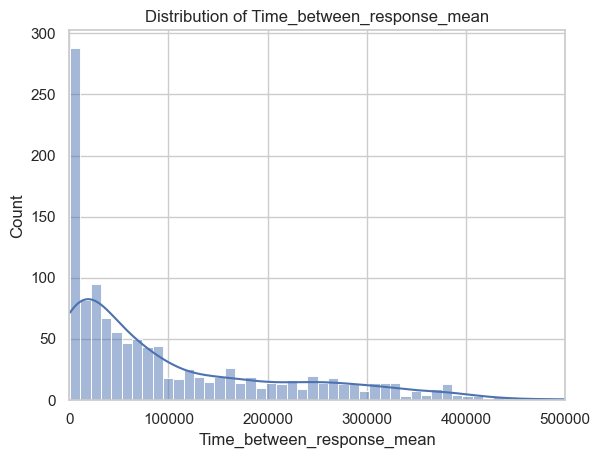

In [973]:
sns.histplot(df1_n_dup['Time_between_response_mean'], bins=50, kde=True)
plt.title('Distribution of Time_between_response_mean')
plt.xlabel('Time_between_response_mean')
plt.xlim(0, 500000)

### We chose to look at feature at half the duration of a question

**Here we can see that as we approach the last days left for the question unique predictors get reduced each day. People mainly change their current predictions** 




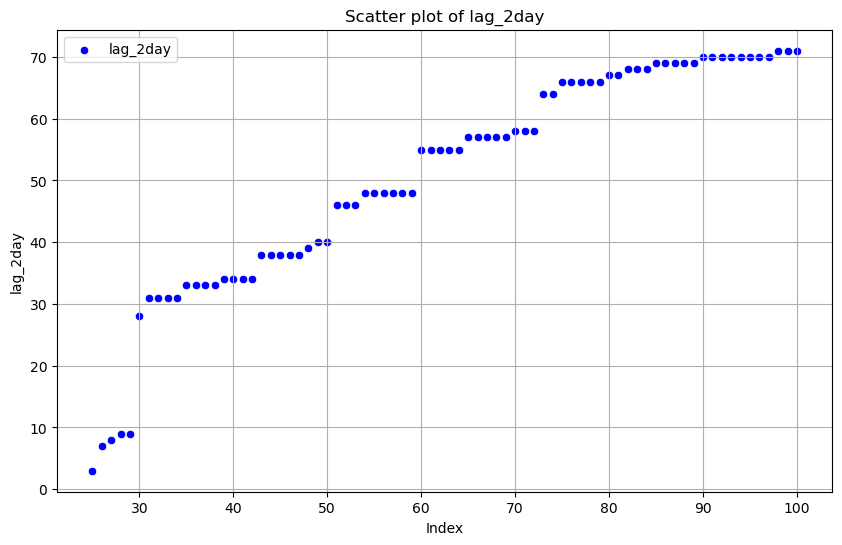

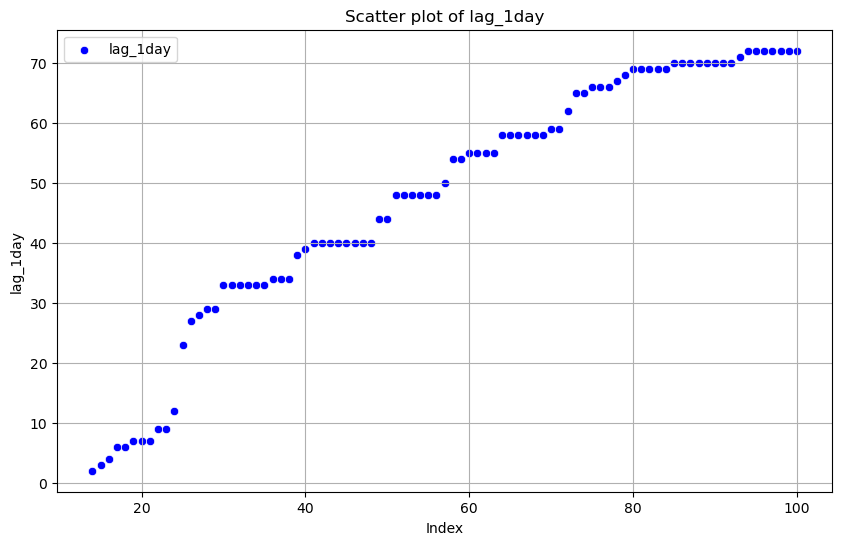

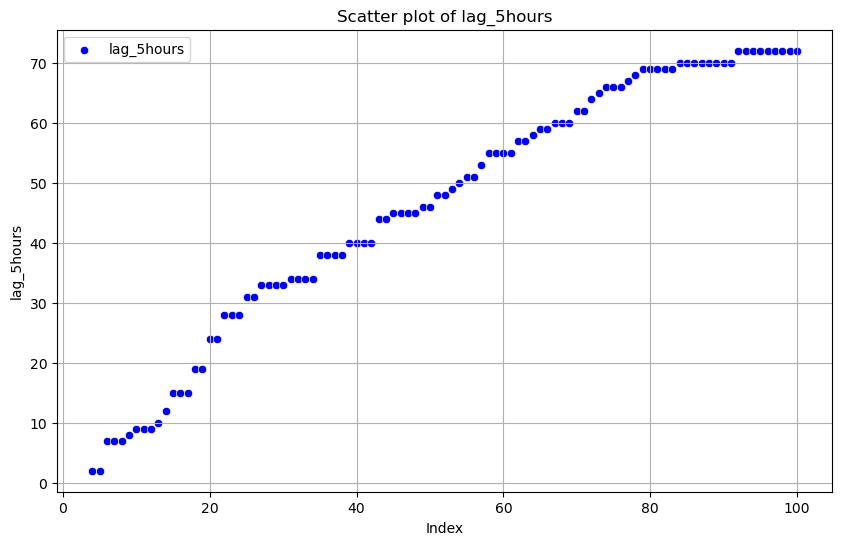

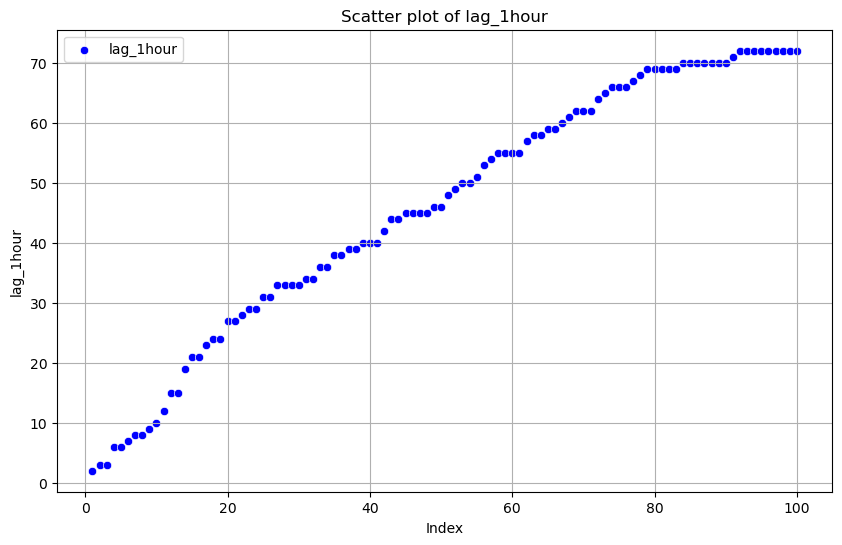

In [960]:
df1_id = df1_no_dup.copy()
df1_id = df1_id[df1_id['id'] == 3444]
import matplotlib.pyplot as plt
lag_cols = ['lag_2day', 'lag_1day', 'lag_5hours', 'lag_1hour']
for col in lag_cols:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df1_id.index, y=df1_id[col], label=col, color='blue')
    plt.title(f'Scatter plot of {col}')
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.show()

## The distributions are not distinct:

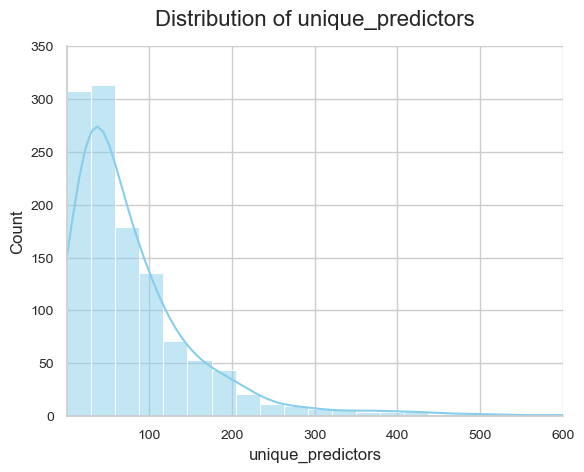

In [969]:
sns.set(style="whitegrid")  # You can choose other themes like "darkgrid", "ticks", etc.

# Create the histogram with KDE
ax = sns.histplot(
    data=df1_n_dup,
    x='unique_predictors',
    bins=50,
    kde=True,
    color='skyblue'  # Customize the color as desired
)

# Customize the plot
ax.set_title('Distribution of unique_predictors', fontsize=16, pad=15)
ax.set_xlabel('unique_predictors', fontsize=12)
ax.set_xlim(1, 600)
ax.set_yticks([0, 50, 100, 150, 200, 250, 300, 350])
ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

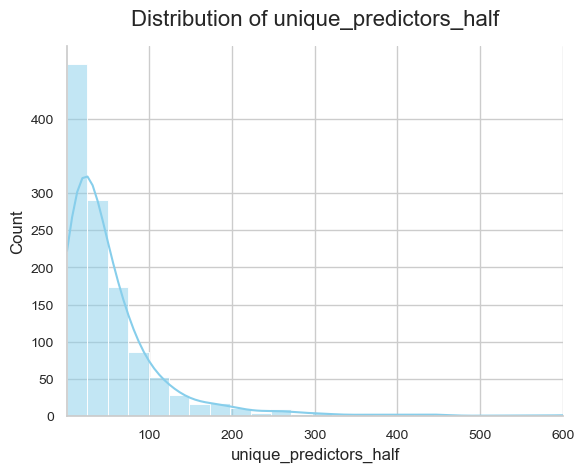

In [967]:
sns.set(style="whitegrid")  # You can choose other themes like "darkgrid", "ticks", etc.

# Create the histogram with KDE
ax = sns.histplot(
    data=df1_n_dup,
    x='unique_predictors_half',
    bins=50,
    kde=True,
    color='skyblue'  # Customize the color as desired
)

# Customize the plot
ax.set_title('Distribution of unique_predictors_half', fontsize=16, pad=15)
ax.set_xlabel('unique_predictors_half', fontsize=12)
ax.set_xlim(1, 600)
ax.set_yticks([0, 50, 100, 150, 200, 250, 300, 400])
ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

### We capture the time between response to learn about the trend

<Axes: ylabel='Time_between_response'>

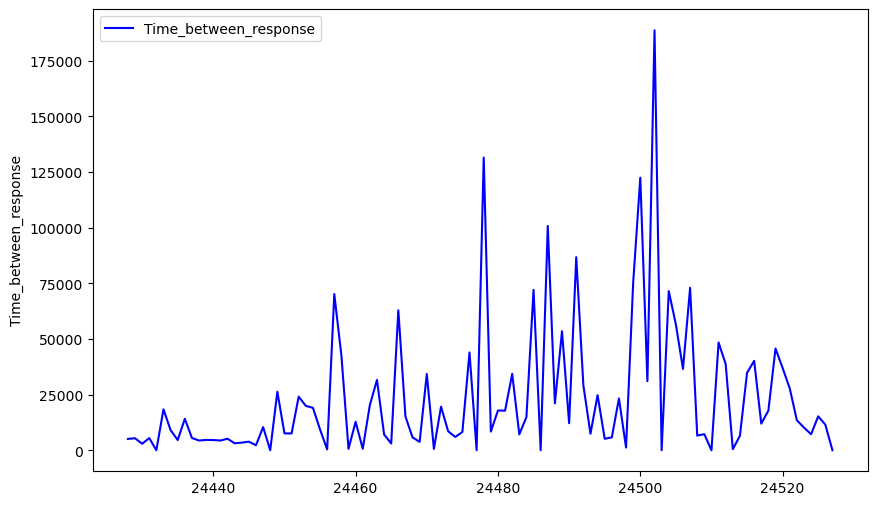

In [794]:
#plot time between response over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df1_id.index, y=df1_id['Time_between_response'], label='Time_between_response', color='blue')

## Sin and Cos features create cycle together

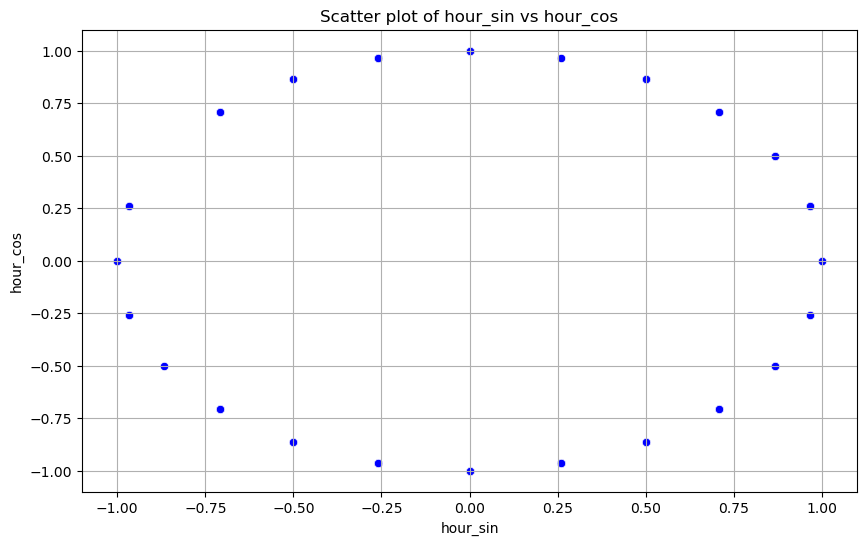

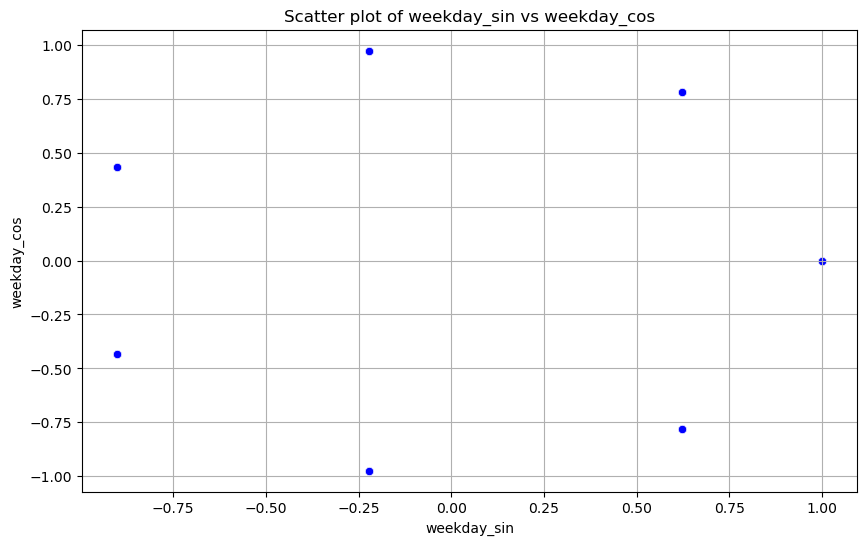

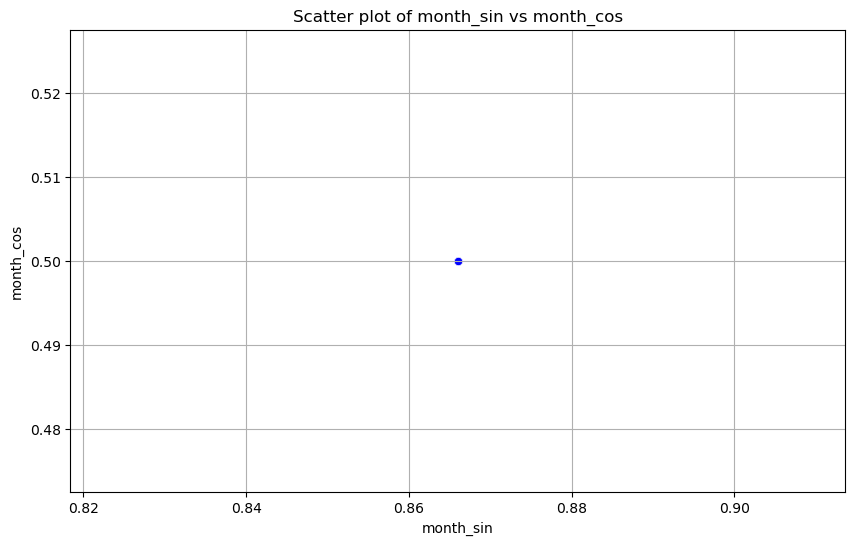

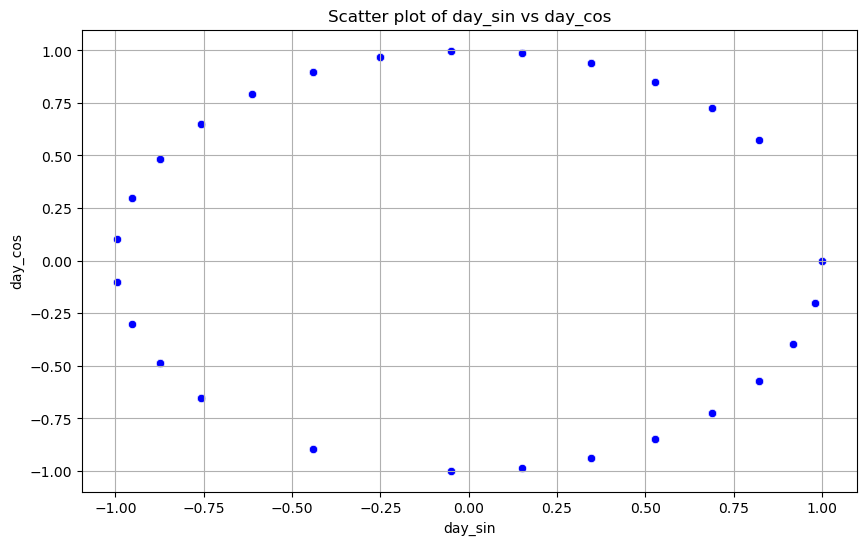

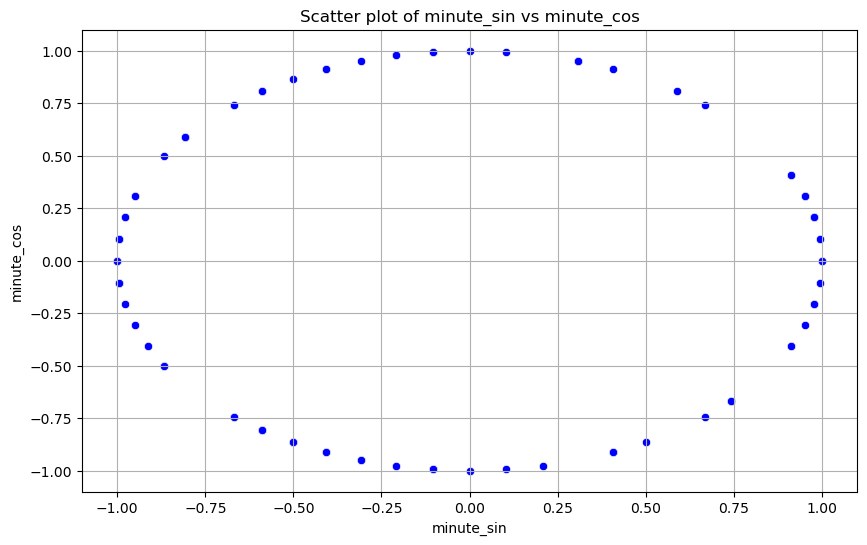

In [821]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming testdf is already defined as your filtered dataframe (id == 3444)

# List of cyclical feature columns (sine and cosine pairs)
list_cols_sine = ['hour_sin', 'weekday_sin', 
                  'month_sin', 'day_sin', 
                  'minute_sin']
list_cols_cosine = ['hour_cos', 'weekday_cos', 'month_cos', 'day_cos', 'minute_cos']

# Plot scatter plots of each pair of sine and cosine features
for sine_col, cosine_col in zip(list_cols_sine, list_cols_cosine):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df1_id[cosine_col], y=df1_id[sine_col], color='blue')
    plt.title(f'Scatter plot of {sine_col} vs {cosine_col}')
    plt.xlabel(sine_col)
    plt.ylabel(cosine_col)
    plt.grid(True)
    plt.show()


In [921]:
import pandas as pd
import numpy as np

# Sample DataFrame (Replace this with your actual df1_post)


# Step 1: Data Preparation
df1_post_cop = df1_post.copy()
df1_post_cop = df1_post_cop.fillna(0)
df1_post_cop.reset_index(inplace=True)  # 'index' column added

# Step 2: Assign relative indices within each 'id'
df1_post_cop['relative_index'] = df1_post_cop.groupby('id').cumcount() + 1  # Starts at 1

# Step 3: Identify the Maximum 'Time_between_response' per 'id'
df_max = df1_post_cop.groupby('id')['Time_between_response'].max().reset_index()
df_max = df_max[df_max['Time_between_response'] != 0]  # Exclude max=0 if desired

# Step 4: Merge to Identify Max Rows
df_merged = pd.merge(
    df1_post_cop,
    df_max,
    on='id',
    how='inner',
    suffixes=('', '_max')
)

# Step 5: Filter Rows with Max 'Time_between_response'
df_max_rows = df_merged[
    (df_merged['Time_between_response'] == df_merged['Time_between_response_max']) &
    (df_merged['Time_between_response'] != 0)
]

# Step 6: Count Number of Max Rows and Get Relative Indices per 'id'
max_count_and_indices = df_max_rows.groupby('id').agg(
    num_max_rows=('Time_between_response', 'size'),
    max_relative_indices=('relative_index', list)  # Collect relative indices as lists
).reset_index()

# Step 7: Calculate Total Number of Rows per 'id'
total_rows_per_id = df1_post_cop.groupby('id').size().reset_index(name='total_rows')

# Step 8: Merge Counts and Calculate Quantile
result = pd.merge(
    max_count_and_indices,
    total_rows_per_id,
    on='id',
    how='left'
)

# Step 9: Calculate Quantile


# Step 10: Handle 'id's with All 'Time_between_response' as 0
# Identify 'id's not present in max_count_and_indices (i.e., all Time_between_response are 0)
ids_with_zero_max = total_rows_per_id[~total_rows_per_id['id'].isin(max_count_and_indices['id'])]['id'].unique()

if len(ids_with_zero_max) > 0:
    df_zero = pd.DataFrame({
        'id': ids_with_zero_max,
        'num_max_rows': 0,
        'max_relative_indices': [[] for _ in ids_with_zero_max],
        'total_rows': df1_post_cop.groupby('id').size()[ids_with_zero_max].values,
        'quantile': 0
    })
    result = pd.concat([result, df_zero], ignore_index=True)
result['max_relative_indices'] = result['max_relative_indices'].apply(lambda x: x[0] if len(x) > 0 else 0)
result['quantile'] = result['max_relative_indices'] / result['total_rows']
# Step 11: Sort the result for better readability
result = result.sort_values(by='id').reset_index(drop=True)

# Display the final result
print(result)


         id  num_max_rows  max_relative_indices  total_rows  quantile
0      3444             1                    76         101  0.752475
1      3446             1                    12         101  0.118812
2      3462             1                    80         101  0.792079
3      3483             1                    43         101  0.425743
4      3487             1                    36         101  0.356436
...     ...           ...                   ...         ...       ...
1184  27980             1                    48          50  0.960000
1185  27981             1                    50          52  0.961538
1186  27982             1                    50          56  0.892857
1187  27983             1                    50          53  0.943396
1188  28006             1                    45          59  0.762712

[1189 rows x 5 columns]


In [922]:
result['quantile'].mean()

0.5642883604534464

In [928]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold,StratifiedKFold
last_entries_1_no_dup = merged_no_duplicates.groupby('id').last()
last_q2_1_no_dup = last_entries_1_no_dup['q2']
y = last_q2_1_no_dup
df_train= df1_n_dup.drop(columns= ['id'])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [873]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold,StratifiedKFold
last_entries_1 = merged_df1.groupby('id').last()
last_q2_1 = last_entries_1['q2']
y = last_q2_1
df_train= df1_n.drop(columns= ['id'])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [262]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold,StratifiedKFold
last_entries_1_new = df_new1.groupby('id').last()
last_q2_1_new = last_entries_1_new['q2']
y_new = last_q2_1_new
df_train_new = df1_n_new.drop(columns= ['id'])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [264]:
rmse = np.sqrt(mean_squared_error(y_new, lgb_pred_on_new))

In [857]:
import optuna
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from optuna.samplers import PartialFixedSampler, TPESampler
import warnings
import logging

# Suppress warnings and set logging level
warnings.filterwarnings('ignore')
logging.getLogger('lightgbm').setLevel(logging.ERROR)

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Define the objective function
def objective(trial):
    # Define parameters to be tuned by Optuna
    params = {
        "extra_trees": True,
        "reg_alpha": trial.suggest_float('reg_alpha', 0.5, 1, log=True),
        "reg_lambda": trial.suggest_float('reg_lambda', 0.4, 0.7, log=True),
        #'max_depth': trial.suggest_int('max_depth', 5, 9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95, log=True),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 0.95, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95, log=True),
        #'subsample_freq': trial.suggest_int('subsample_freq', 15, 20),
        #'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
        # Add more parameters if needed
    }


    rmse_list = []
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    for idx_train, idx_valid in kf.split(df_train):
        X_train, y_train_fold = df_train.iloc[idx_train], y.iloc[idx_train]
        X_valid, y_valid_fold = df_train.iloc[idx_valid], y.iloc[idx_valid]

        # Initialize and train the model
        model = LGBMRegressor(
            num_leaves=fixed_params['num_leaves'],  # Fixed parameter
            n_estimators=fixed_params['n_estimators'],  # Fixed parameter
            verbose=fixed_params['verbose'],
            boosting_type=fixed_params['boosting_type'],
            objective=fixed_params['objective'],
            metric=fixed_params['metric'],
            learning_rate=fixed_params['learning_rate'],  # Fixed parameter
            max_depth=fixed_params['max_depth'],  # Fixed parameter
            subsample_freq=fixed_params['subsample_freq'],  # Fixed parameter
            min_child_samples=fixed_params['min_child_samples'],  # Fixed parameter
            **params,  # Tuned parameters
            random_state=RANDOM_SEED
        )

        model.fit(
            X_train, y_train_fold,
            eval_set=[(X_valid, y_valid_fold)],
            eval_metric='rmse',

        )

        # Predict and calculate RMSE
        y_pred = model.predict(X_valid, num_iteration=model.best_iteration_)
        rmse = mean_squared_error(y_valid_fold, y_pred, squared=False)
        rmse_list.append(rmse)

    # Return the average RMSE across folds
    mean_rmse = np.mean(rmse_list)
    return mean_rmse

# Define fixed parameters
fixed_params = {'max_depth':8,
    'verbose': -1,
    "boosting_type": "gbdt",
    'num_leaves': 64,  # Fixed parameter
    "objective": "regression",
     'learning_rate': 0.01,
     'subsample_freq': 200,
    "metric": "rmse",
    'min_child_samples': 4,

   
    'n_estimators': 2000,  # Fixed parameter
    'early_stopping_round': 1000,
}

# Create a study with PartialFixedSampler
study = optuna.create_study(direction='minimize', sampler= TPESampler(seed=42))
fixed_sampler = PartialFixedSampler(fixed_params, study.sampler)
study.sampler = fixed_sampler

# Optimize the study
study.optimize(objective, n_trials=30)

# Display the best trial
print("Best Trial:")
trial = study.best_trial
print(f"  Value (RMSE): {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-10-03 13:56:56,265] A new study created in memory with name: no-name-4cd995fe-0f20-4270-8cef-e46888857b46
[I 2024-10-03 13:57:03,576] Trial 0 finished with value: 0.3059064725588409 and parameters: {'reg_alpha': 0.6482131165247735, 'reg_lambda': 0.6809570824453028, 'colsample_bytree': 0.8399182254029082, 'colsample_bynode': 0.7899997136252964, 'subsample': 0.6445969672310304}. Best is trial 0 with value: 0.3059064725588409.
[I 2024-10-03 13:57:13,033] Trial 1 finished with value: 0.30531998447849773 and parameters: {'reg_alpha': 0.5570947094409952, 'reg_lambda': 0.41321541936307926, 'colsample_bytree': 0.8933385256691748, 'colsample_bynode': 0.7908920113662501, 'subsample': 0.8307358682527632}. Best is trial 1 with value: 0.30531998447849773.
[I 2024-10-03 13:57:21,824] Trial 2 finished with value: 0.30704785170564675 and parameters: {'reg_alpha': 0.5071851795705947, 'reg_lambda': 0.688311442289429, 'colsample_bytree': 0.8795970993799664, 'colsample_bynode': 0.6614975906952201,

Best Trial:
  Value (RMSE): 0.3042888839731138
  Params:
    reg_alpha: 0.510843433276398
    reg_lambda: 0.5758815394477095
    colsample_bytree: 0.6603126150898777
    colsample_bynode: 0.8625942585381968
    subsample: 0.8764818166434032


In [858]:
trial

FrozenTrial(number=18, state=1, values=[0.3042888839731138], datetime_start=datetime.datetime(2024, 10, 3, 13, 59, 30, 321631), datetime_complete=datetime.datetime(2024, 10, 3, 13, 59, 39, 719331), params={'reg_alpha': 0.510843433276398, 'reg_lambda': 0.5758815394477095, 'colsample_bytree': 0.6603126150898777, 'colsample_bynode': 0.8625942585381968, 'subsample': 0.8764818166434032}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'reg_alpha': FloatDistribution(high=1.0, log=True, low=0.5, step=None), 'reg_lambda': FloatDistribution(high=0.7, log=True, low=0.4, step=None), 'colsample_bytree': FloatDistribution(high=0.95, log=True, low=0.6, step=None), 'colsample_bynode': FloatDistribution(high=0.95, log=True, low=0.6, step=None), 'subsample': FloatDistribution(high=0.95, log=True, low=0.6, step=None)}, trial_id=18, value=None)

In [860]:
trial_params = {'reg_alpha': 0.510843433276398, 'reg_lambda': 0.5758815394477095, 'colsample_bytree': 0.6603126150898777, 'colsample_bynode': 0.8625942585381968, 'subsample': 0.8764818166434032}
all_fParams = {**fixed_params, **trial_params}
all_fParams

{'max_depth': 8,
 'verbose': -1,
 'boosting_type': 'gbdt',
 'num_leaves': 64,
 'objective': 'regression',
 'learning_rate': 0.01,
 'subsample_freq': 200,
 'metric': 'rmse',
 'min_child_samples': 4,
 'n_estimators': 2000,
 'early_stopping_round': 1000,
 'reg_alpha': 0.510843433276398,
 'reg_lambda': 0.5758815394477095,
 'colsample_bytree': 0.6603126150898777,
 'colsample_bynode': 0.8625942585381968,
 'subsample': 0.8764818166434032}

In [929]:
np.random.seed(42)
import warnings 
warnings.filterwarnings('ignore')
# df_train is the training dataframe and y is the target variable
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",  # Use a regression metric
    "max_depth": 10,  
    "learning_rate": 0.05,
    #"n_estimators": 2000,  
    "colsample_bytree": 0.68,
    'scale_pos_weight': 50,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':64}

famParams = {'verbose': -1,
 'boosting_type': 'gbdt',
 'num_leaves': 64,
 'objective': 'regression',
 'learning_rate': 0.01,
 'metric': 'rmse',
 'n_estimators': 2000,
 'early_stopping_round': 1000,
 'reg_alpha': 0.12776485418442662,
 'reg_lambda': 1.7023282716867387,
 'max_depth': 7,
 'colsample_bytree': 0.9138159148710222,
 'colsample_bynode': 0.8879864738697725,
 'subsample': 0.7747174812920734,
 'subsample_freq': 10}
 

This_the_one = {'max_depth': 8,
 'verbose': -1,
 'boosting_type': 'gbdt',
 'num_leaves': 64,
 'objective': 'regression',
 'learning_rate': 0.02,
 'subsample_freq': 200,
 'metric': 'rmse',
 'min_child_samples': 4,
 'n_estimators': 2000,
 'early_stopping_round': 1000,
 'reg_alpha': 0.6150823851877983,
 'reg_lambda': 0.4019513141970534,
 'colsample_bytree': 0.9381694254851193,
 'colsample_bynode': 0.6144874410854747,
 'subsample': 0.8365551463780401}

This_no_dup = {'max_depth': 8,
 'verbose': -1,
 'boosting_type': 'gbdt',
 'num_leaves': 64,
 'objective': 'regression',
 'learning_rate': 0.01,
 'subsample_freq': 200,
 'metric': 'rmse',
 'min_child_samples': 4,
 'n_estimators': 2000,
 'early_stopping_round': 1000,
 'reg_alpha': 0.510843433276398,
 'reg_lambda': 0.5758815394477095,
 'colsample_bytree': 0.6603126150898777,
 'colsample_bynode': 0.8625942585381968,
 'subsample': 0.8764818166434032}

second_try_with_full = {'max_depth': 7,
 'verbose': -1,
 'boosting_type': 'gbdt',
 'num_leaves': 62,
 'objective': 'regression',
 'learning_rate': 0.01,
 'metric': 'rmse',
 'n_estimators': 2000,
 'early_stopping_round': 1000,
 'reg_alpha': 0.09099694632498756,
 'reg_lambda': 0.03124565071260872,
 'colsample_bytree': 0.656967498247354,
 'colsample_bynode': 0.634913994829205,
 'subsample': 0.8477107305826747,
 'subsample_freq': 17}

all_fParams = {'verbose': -1,
 'boosting_type': 'gbdt',
 'num_leaves': 64,
 'objective': 'regression',
 'learning_rate': 0.01,
 'metric': 'rmse',
 'n_estimators': 2000,
 'early_stopping_round': 1000,
 'reg_alpha': 2.275151647466187,
 'reg_lambda': 0.5450853190672589,
 'max_depth': 8,
 'colsample_bytree': 0.5070512158501231,
 'colsample_bynode': 0.731892041822454,
 'subsample': 0.8477107305826747,
 'subsample_freq': 200,
 'min_child_samples': 4}

yes = {'max_depth': 7,
 'verbose': -1,
 'boosting_type': 'gbdt',
 'num_leaves': 64,
 'objective': 'regression',
 'learning_rate': 0.01,
 'colsample_bynode': 0.7213119034589016,
 'metric': 'rmse',
 'n_estimators': 2000,
 'early_stopping_round': 1000,
 'reg_alpha': 0.1354257889529087,
 'reg_lambda': 0.6296666551107852,
 'colsample_bytree': 0.40777229024125294,
 'subsample': 0.7794003430173266,
 'subsample_freq': 12}

lst_try = {'verbose': -1,
 'boosting_type': 'gbdt',
 'num_leaves': 64,
 'objective': 'regression',
 'learning_rate': 0.05,
 'metric': 'rmse',
 'n_estimators': 2000,
 'reg_alpha': 2.4992188841592546,
 'reg_lambda': 0.3302239707082332,
 'max_depth': 4,
 'colsample_bytree': 0.5250094467242431,
 'colsample_bynode': 0.7932460915376365,
 'subsample': 0.7537675614533189,
 'subsample_freq': 2}
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import lightgbm as lgb
import numpy as np

# Assuming df_trainis the training dataframe and y_new is the target variable
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fitted_models_lgb = []
cv_scores_lgb = []
iters = []
learning_curves= []
for idx_train, idx_valid in kf.split(df_train):
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    
    # Define LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    # Train LightGBM model
    lgb_model = lgb.train(This_the_one, train_data, valid_sets=[valid_data],
                      callbacks=[lgb.log_evaluation(200), lgb.early_stopping(1000)])
    # Evaluate model on validation data
    y_pred_valid = lgb_model.predict(X_valid)
    rmse_score = root_mean_squared_error(y_valid, y_pred_valid)  # RMSE
    
    # Store model and score
    fitted_models_lgb.append(lgb_model)
    cv_scores_lgb.append(rmse_score)
    learning_curves.append(rmse_score)
    iters.append(idx_train)

# Display CV RMSE scores
print("CV RMSE scores: ", cv_scores_lgb)
print("min CV RMSE score: ", min(cv_scores_lgb))
print("Max CV RMSE score: ", max(cv_scores_lgb))
print("Mean CV RMSE score: ", np.mean(cv_scores_lgb))



Training until validation scores don't improve for 1000 rounds
[200]	valid_0's rmse: 0.294335
[400]	valid_0's rmse: 0.300548
[600]	valid_0's rmse: 0.30054
[800]	valid_0's rmse: 0.300413
[1000]	valid_0's rmse: 0.30036
Training until validation scores don't improve for 1000 rounds
[200]	valid_0's rmse: 0.332461
[400]	valid_0's rmse: 0.33735
[600]	valid_0's rmse: 0.336904
[800]	valid_0's rmse: 0.335438
[1000]	valid_0's rmse: 0.335053
Early stopping, best iteration is:
[55]	valid_0's rmse: 0.325594
Training until validation scores don't improve for 1000 rounds
[200]	valid_0's rmse: 0.301851
[400]	valid_0's rmse: 0.302874
[600]	valid_0's rmse: 0.301819
[800]	valid_0's rmse: 0.301168
[1000]	valid_0's rmse: 0.300807
[1200]	valid_0's rmse: 0.300807
[1400]	valid_0's rmse: 0.300807
[1600]	valid_0's rmse: 0.300807
[1800]	valid_0's rmse: 0.300807
Training until validation scores don't improve for 1000 rounds
[200]	valid_0's rmse: 0.295981
[400]	valid_0's rmse: 0.297627
[600]	valid_0's rmse: 0.2963

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

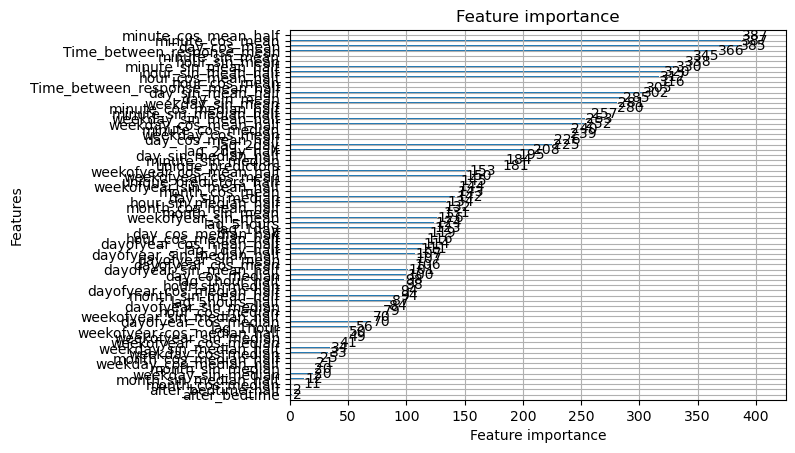

In [876]:
lgb.plot_importance(lgb_model)

## XGB

In [877]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import LabelEncoder

# Function to generate features
def Feature_generation(df1):
    # Convert 'publish_time' and 'Response_date' to datetime
    df1['publish_time'] = pd.to_datetime(df1['publish_time'])
    df1['Response_date'] = pd.to_datetime(df1['Response_date'], errors='coerce')

    # Step 1: Extract time features
    df1 = extract_time_features(df1)

    # Step 2: Generate cyclical features
    df1 = generate_cyclical_features(df1)

    # Step 3: Generate bedtime feature
    df1 = generate_bedtime_feature(df1)

    # Step 4: Calculate mean and median for full and half datasets
    full_means, full_medians = calculate_agg_features(df1)
    half_df = df1.groupby('id').apply(get_half_rows).reset_index(drop=True)
    half_means, half_medians = calculate_agg_features(half_df)

    # Step 5: Add lag features
    lag_intervals = {'lag_2day': 2 * 24 * 60 * 60, 'lag_1day': 24 * 60 * 60, 'lag_5hours': 5 * 60 * 60, 'lag_1hour': 60 * 60}
    df1 = calculate_lag_features(df1, lag_intervals)

    # Step 6: Last q2 and unique predictors
    last_entries = df1.groupby('id').last()
    last_q2 = last_entries['q2']
    unique_predictors = df1.groupby('id')['Unique_predictors'].max().reset_index().iloc[:,1]

    # Step 7: Combine all features
    lag_features = {
        'lag_2day': df1.groupby('id')['lag_2day'].first().reset_index().iloc[:,1],
        'lag_1day': df1.groupby('id')['lag_1day'].first().reset_index().iloc[:,1],
        'lag_5hours': df1.groupby('id')['lag_5hours'].first().reset_index().iloc[:,1],
        'lag_1hour': df1.groupby('id')['lag_1hour'].first().reset_index().iloc[:,1],
    }

    # Combine both full and half data aggregation
    df1_n_full = combine_features(df1, full_means, full_medians, unique_predictors, lag_features)
    df1_n_half = combine_features(half_df, half_means, half_medians, unique_predictors, lag_features)
    df1_n_half = df1_n_half.drop(columns = ['id','unique_predictors'])

    #Add half suffix to the half features
    df1_n_half.columns = [f'{col}_half' if col not in ['id', 'unique_predictors'] else col for col in df1_n_half.columns]
    #combinig the two dataframes
    df1_n = pd.concat([df1_n_full, df1_n_half], axis=1)

    return df1_n 

# Preparing target variable
last_entries_1 = merged_df1.groupby('id').last()
last_q2_1 = last_entries_1['q2']
y = last_q2_1
df_train = df1_n.drop(columns= ['id'])

# Convert the training set to DMatrix (XGBoost's preferred structure)
dtrain = xgb.DMatrix(df_train, label=y)

# XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6,
    'colsample_bynode': 0.8,
    'alpha': 0.1,
    'lambda': 10,
    'n_estimators': 2000,
    'seed': 42
}

all_fParams = {'verbose': -1,
 
 'num_leaves': 64,
 'objective': 'reg:squarederror',
 'learning_rate': 0.01,
 'metric': 'rmse',
 'n_estimators': 2000,
 'early_stopping_round': 1000,
 'reg_alpha': 2.275151647466187,
 'reg_lambda': 0.5450853190672589,
 'max_depth': 8,
 'colsample_bytree': 0.5070512158501231,
 'colsample_bynode': 0.731892041822454,
 'subsample': 0.8477107305826747,
 'subsample_freq': 200,
 'min_child_weight': 2}

This_the_one = {'max_depth': 8,
 'verbose': -1,
 'objective': 'reg:squarederror',
 'num_leaves': 64,
 'learning_rate': 0.02,
 'subsample_freq': 200,
 'metric': 'rmse',
 'min_child_samples': 4,
 'n_estimators': 2000,
 'early_stopping_round': 1000,
 'reg_alpha': 0.6150823851877983,
 'reg_lambda': 0.4019513141970534,
 'colsample_bytree': 0.9381694254851193,
 'colsample_bynode': 0.6144874410854747,
 'subsample': 0.8365551463780401}

# Setting up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store models and CV scores
fitted_models_xgb = []
cv_scores_xgb = []
learning_curves = []

# Training and evaluating the model using cross-validation
for idx_train, idx_valid in kf.split(df_train, y):
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    xgb_model = xgb.train(params=This_the_one, dtrain=dtrain, num_boost_round=2000, evals=[(dvalid, 'eval')],
                      early_stopping_rounds=50, verbose_eval=200)
    
    y_pred_valid = xgb_model.predict(dvalid)
    rmse_score = np.sqrt(mean_squared_error(y_valid, y_pred_valid))  # RMSE
    
    # Store model and CV score
    fitted_models_xgb.append(xgb_model)
    cv_scores_xgb.append(rmse_score)

# Display the cross-validation RMSE scores
print("CV RMSE scores: ", cv_scores_xgb)
print("Min CV RMSE score: ", min(cv_scores_xgb))
print("Max CV RMSE score: ", max(cv_scores_xgb))
print("Mean CV RMSE score: ", np.mean(cv_scores_xgb))

[0]	eval-rmse:0.30887
[151]	eval-rmse:0.29457
[0]	eval-rmse:0.33524
[91]	eval-rmse:0.32782
[0]	eval-rmse:0.31992
[200]	eval-rmse:0.29398
[233]	eval-rmse:0.29425
[0]	eval-rmse:0.31132
[164]	eval-rmse:0.29504
[0]	eval-rmse:0.32517
[165]	eval-rmse:0.29647
CV RMSE scores:  [0.2945688613038478, 0.3277834868672072, 0.29426989082955923, 0.29503758028276483, 0.29647059852749413]
Min CV RMSE score:  0.29426989082955923
Max CV RMSE score:  0.3277834868672072
Mean CV RMSE score:  0.3016260835621746


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

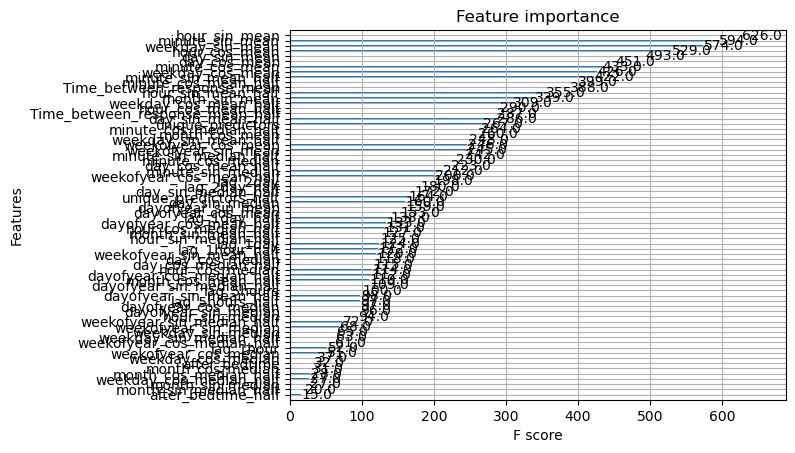

In [879]:
xgb.plot_importance(xgb_model) 

### Catboost

In [880]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Assuming df_train is the training dataframe and y is the target variable
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fitted_models_catboost = []
cv_scores_catboost = []
learning_curves = []

# Define CatBoost parameters
catboost_params = {
    'iterations': 2000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'RMSE',  # For regression
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'verbose': 200,
    'early_stopping_rounds': 50
}

# Training and evaluating the model using cross-validation
for idx_train, idx_valid in kf.split(df_train):
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    
    # Convert the data to Pool objects for CatBoost
    train_pool = Pool(X_train, y_train)
    valid_pool = Pool(X_valid, y_valid)
    
    # Train the CatBoost model
    cat_model = CatBoostRegressor(**catboost_params)
    cat_model.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    
    # Predict and calculate RMSE on validation data
    y_pred_valid = cat_model.predict(X_valid)
    rmse_score = np.sqrt(mean_squared_error(y_valid, y_pred_valid))  # RMSE
    
    # Store model and score
    fitted_models_catboost.append(cat_model)
    cv_scores_catboost.append(rmse_score)

# Display the cross-validation RMSE scores
print("CV RMSE scores: ", cv_scores_catboost)
print("Min CV RMSE score: ", min(cv_scores_catboost))
print("Max CV RMSE score: ", max(cv_scores_catboost))
print("Mean CV RMSE score: ", np.mean(cv_scores_catboost))

0:	learn: 0.3218696	test: 0.3079351	best: 0.3079351 (0)	total: 15.9ms	remaining: 31.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3010512171
bestIteration = 43

Shrink model to first 44 iterations.
0:	learn: 0.3142752	test: 0.3349838	best: 0.3349838 (0)	total: 11.8ms	remaining: 23.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3288999058
bestIteration = 40

Shrink model to first 41 iterations.
0:	learn: 0.3194595	test: 0.3194815	best: 0.3194815 (0)	total: 11ms	remaining: 22s
200:	learn: 0.2063572	test: 0.3010563	best: 0.3005593 (165)	total: 899ms	remaining: 8.04s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3005593086
bestIteration = 165

Shrink model to first 166 iterations.
0:	learn: 0.3209027	test: 0.3113453	best: 0.3113453 (0)	total: 10.2ms	remaining: 20.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2973205022
bestIteration = 61

Shrink model to first 62 iterations.
0:	learn: 0.3176433	

### NGboost

# Doesnt work with Nas

In [882]:
df_train1 = df_train.copy()
df_train1.dropna(inplace=True)

In [883]:
import pandas as pd
import numpy as np
from ngboost import NGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import warnings


# Assuming df_train is the training dataframe and y is the target variable
kf = KFold(n_splits=5, shuffle=True, random_state=42)

    
fitted_models_ngboost = []
cv_scores_ngboost = []
learning_curves = []

# Define NGBoost parameters
ngb_params = {
    'n_estimators': 2000,
    'learning_rate': 0.05,
    'minibatch_frac': 1.0,  # Set to 1.0 to use the full dataset at each step
    'natural_gradient': True,
    'verbose': True,
    'random_state': 42
}

# Training and evaluating the model using cross-validation
for idx_train, idx_valid in kf.split(df_train1):
    X_train, y_train = df_train1.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = df_train1.iloc[idx_valid], y.iloc[idx_valid]
    
    # Train the NGBoost model
    model = NGBRegressor(**ngb_params)
    model.fit(X_train, y_train, X_val=X_valid, Y_val=y_valid, early_stopping_rounds=50)
    
    # Predict and calculate RMSE on validation data
    y_pred_valid = model.predict(X_valid)
    rmse_score = np.sqrt(mean_squared_error(y_valid, y_pred_valid))  # RMSE
    
    # Store model and score
    fitted_models_ngboost.append(model)
    cv_scores_ngboost.append(rmse_score)

# Display the cross-validation RMSE scores
print("CV RMSE scores: ", cv_scores_ngboost)
print("Min CV RMSE score: ", min(cv_scores_ngboost))
print("Max CV RMSE score: ", max(cv_scores_ngboost))
print("Mean CV RMSE score: ", np.mean(cv_scores_ngboost))

[iter 0] loss=0.3010 val_loss=0.2676 scale=1.0000 norm=0.5350
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=0.2406)
[iter 0] loss=0.2832 val_loss=0.3406 scale=1.0000 norm=0.5386
== Early stopping achieved.
== Best iteration / VAL28 (val_loss=0.3072)
[iter 0] loss=0.2927 val_loss=0.3021 scale=1.0000 norm=0.5308
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=0.2750)
[iter 0] loss=0.2989 val_loss=0.2754 scale=1.0000 norm=0.5357
== Early stopping achieved.
== Best iteration / VAL22 (val_loss=0.2550)
[iter 0] loss=0.2958 val_loss=0.2887 scale=1.0000 norm=0.5398
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=0.2865)
CV RMSE scores:  [0.3148643795639342, 0.32909812439013275, 0.32620809928661204, 0.3150243073827003, 0.32332330752047367]
Min CV RMSE score:  0.3148643795639342
Max CV RMSE score:  0.32909812439013275
Mean CV RMSE score:  0.3217036436287706


In [638]:
df_train

,hour_sin_mean,weekday_sin_mean,month_sin_mean,day_sin_mean,minute_sin_mean,weekofyear_sin_mean,dayofyear_sin_mean,hour_cos_mean,weekday_cos_mean,month_cos_mean,...,minute_cos_median_half,weekofyear_cos_median_half,dayofyear_cos_median_half,unique_predictors_half,after_bedtime_half,Time_between_response_mean_half,lag_2day_half,lag_1day_half,lag_5hours_half,lag_1hour_half
0,-0.175813,-0.185711,0.500000,0.263370,-0.057326,0.307105,0.237870,0.136058,0.023578,8.660254e-01,...,-0.156220,0.982502,0.995484,48.0,0.0,12842.266325,40.0,44.0,46.0,46.0
1,-0.093541,-0.040902,-0.015823,-0.034004,0.018913,0.018082,0.019079,0.330062,0.028965,-1.138614e-01,...,0.307324,-0.088796,-0.012908,122.0,0.0,287129.343143,109.0,109.0,109.0,109.0
2,-0.176153,0.010672,0.053129,0.070105,0.034046,0.075199,0.072968,-0.020887,-0.051380,-3.597995e-02,...,0.104528,0.147647,0.183992,187.0,0.0,234156.360557,183.0,183.0,183.0,183.0
3,-0.102561,0.049605,-0.055071,-0.104461,0.040322,-0.075349,-0.075729,0.060624,0.014382,1.362211e-01,...,0.156220,-0.088796,-0.047314,73.0,0.0,361419.912992,70.0,72.0,72.0,72.0
4,-0.123812,0.014935,-0.019802,-0.056327,-0.156777,-0.025658,-0.024256,0.059251,0.001913,1.082000e-01,...,-0.052264,-0.088796,-0.021509,108.0,0.0,319981.295159,106.0,107.0,107.0,107.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184,-0.503507,-0.531272,-1.000000,0.946881,0.113429,-0.902798,-0.918791,-0.385162,-0.778848,-1.836970e-16,...,0.743145,-0.430065,-0.397543,9.0,0.0,140.776134,NaN,NaN,NaN,NaN
1185,-0.535478,-0.527526,-1.000000,0.946530,0.274285,-0.902798,-0.918744,-0.378173,-0.783545,-1.836970e-16,...,0.743145,-0.430065,-0.397543,9.0,0.0,117.636003,NaN,NaN,NaN,NaN
1186,-0.515758,-0.559483,-1.000000,0.949526,0.165397,-0.902798,-0.919141,-0.427624,-0.743472,-1.836970e-16,...,0.776081,-0.430065,-0.397543,10.0,0.0,173.470163,NaN,NaN,NaN,3.0
1187,-0.557887,-0.535968,-1.000000,0.947321,0.308133,-0.902798,-0.918849,-0.355208,-0.772960,-1.836970e-16,...,0.776081,-0.430065,-0.397543,10.0,0.0,213.557193,NaN,NaN,NaN,6.0


# Voting regressor

In [884]:
from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

for idx_train, idx_valid in kf.split(df_train):
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
# LightGBM Regressor
lgb_model = LGBMRegressor(
    #verbose= 0,
    boosting_type='gbdt',
    num_leaves=64,
    objective='regression',
    learning_rate=0.05,
    metric='rmse',
    n_estimators=2000,
    reg_alpha=2.4992188841592546,
    reg_lambda=0.3302239707082332,
    max_depth=4,
    colsample_bytree=0.5250094467242431,
    subsample=0.7537675614533189,
    subsample_freq=2
)
lgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

# XGBoost Regressor
# XGBoost Regressor
# XGBoost Regressor
xgb_model = XGBRegressor(
    verbosity=1,  # Ensure verbosity is set correctly
    objective='reg:squarederror',
    learning_rate=0.01,
    n_estimators=2000,
    reg_alpha=2.275151647466187,
    reg_lambda=0.5450853190672589,
    max_depth=8,
    colsample_bytree=0.5070512158501231,
    colsample_bynode=0.731892041822454,
    subsample=0.8477107305826747,
    min_child_weight=2
)

# Fit the model without the 'verbose' parameter
#xgb_model.fit(df_train, y, eval_set=[(df_train, y)], verbose_eval=True)

xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=1)
# CatBoost Regressor
cat_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',  # For regression
    eval_metric='RMSE',
    random_seed=42,
    #verbose= 0  # Suppress output
    # early_stopping_rounds handled during fit if needed
)
cat_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=1)

# Create VotingRegressor with unfitted models
voting_reg = VotingRegressor([
    ('lgb', lgb_model),
    ('xgb', xgb_model),
    ('cat', cat_model)
])


# Fit the VotingRegressor
voting_reg.fit(X_train, y_train)

# Make predictions
y_pred = voting_reg.predict(X_valid)

rmse_score = np.sqrt(mean_squared_error(y_valid, y_pred))  # RMSE


[0]	validation_0-rmse:0.32597
[1]	validation_0-rmse:0.32571
[2]	validation_0-rmse:0.32523
[3]	validation_0-rmse:0.32502
[4]	validation_0-rmse:0.32456
[5]	validation_0-rmse:0.32432
[6]	validation_0-rmse:0.32384
[7]	validation_0-rmse:0.32344
[8]	validation_0-rmse:0.32300
[9]	validation_0-rmse:0.32275
[10]	validation_0-rmse:0.32249
[11]	validation_0-rmse:0.32209
[12]	validation_0-rmse:0.32174
[13]	validation_0-rmse:0.32149
[14]	validation_0-rmse:0.32128
[15]	validation_0-rmse:0.32090
[16]	validation_0-rmse:0.32060
[17]	validation_0-rmse:0.32023
[18]	validation_0-rmse:0.31991
[19]	validation_0-rmse:0.31957
[20]	validation_0-rmse:0.31928
[21]	validation_0-rmse:0.31908
[22]	validation_0-rmse:0.31885
[23]	validation_0-rmse:0.31875
[24]	validation_0-rmse:0.31862
[25]	validation_0-rmse:0.31832
[26]	validation_0-rmse:0.31800
[27]	validation_0-rmse:0.31779
[28]	validation_0-rmse:0.31750
[29]	validation_0-rmse:0.31727
[30]	validation_0-rmse:0.31717
[31]	validation_0-rmse:0.31689
[32]	validation_0-

In [890]:
df1_n_test,df1_test = Feature_generation(merged_df_test)

In [896]:
last_entries_1_test = merged_test.groupby('id').last()
last_q2_1_test = last_entries_1_test['q2']
y_test = last_q2_1_test
df_test= df1_n_test.drop(columns= ['id'])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [930]:
xg_df_test = xgb.DMatrix(df_test, label=y_test)

lgb_pred_new = lgb_model.predict(df_test)

xgb_pred_new = xgb_model.predict(df_test)
cat_pred_new = cat_model.predict(df_test)
voting_pred_new = voting_reg.predict(df_test)

In [931]:
print("LightGBM RMSE on new data: ", np.sqrt(mean_squared_error(y_test, lgb_pred_new)))
print("XGBoost RMSE on new data: ", np.sqrt(mean_squared_error(y_test, xgb_pred_new)))
print("CatBoost RMSE on new data: ", np.sqrt(mean_squared_error(y_test, cat_pred_new)))
print("VotingRegressor RMSE on new data: ", np.sqrt(mean_squared_error(y_test, voting_pred_new)))

LightGBM RMSE on new data:  0.2912172102064591
XGBoost RMSE on new data:  0.30008223852871224
CatBoost RMSE on new data:  0.29664033731021294
VotingRegressor RMSE on new data:  0.3009423966938932


**We've worked extensively on improving the LGB model so we got better results. Moving on, we would like to improve our catboost and XGboost models as well.**

In [940]:
lgb_class = np.where(lgb_pred_new > 0.5, 1, 0)
xgb_class = np.where(xgb_pred_new > 0.5, 1, 0)
cat_class = np.where(cat_pred_new > 0.5, 1, 0)
voting_class = np.where(voting_pred_new > 0.5, 1, 0)
Community = np.where(y_test > 0.5, 1, 0)


In [935]:
result_vector = merged_test.groupby('id').last()['Result']

In [942]:
from sklearn.metrics import accuracy_score
# Compare
print("LightGBM Accuracy on new data: ", accuracy_score(result_vector, lgb_class))
print("XGBoost Accuracy on new data: ", accuracy_score(result_vector, xgb_class))
print("CatBoost Accuracy on new data: ", accuracy_score(result_vector, cat_class))
print("VotingRegressor Accuracy on new data: ", accuracy_score(result_vector, voting_class))
print("Community Accuracy on new data: ", accuracy_score(result_vector, Community))

LightGBM Accuracy on new data:  0.6695156695156695
XGBoost Accuracy on new data:  0.6581196581196581
CatBoost Accuracy on new data:  0.6780626780626781
VotingRegressor Accuracy on new data:  0.6666666666666666
Community Accuracy on new data:  0.811965811965812


*Surprisingly the model who predicted best the correct outcome is first of all 'humans' model, than Catboost*